# Optimising the DEMO design under uncertainty

This work introduces a statistical approach for evaluating power plant designs
under uncertainty and optimising for reliability 
and confidence in the design.


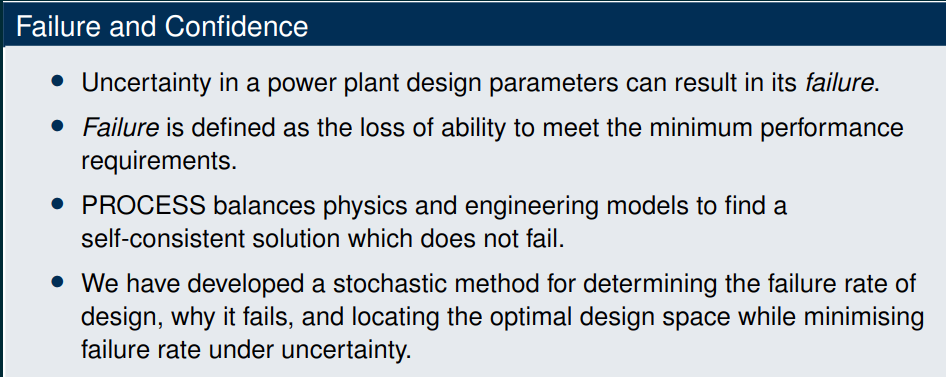

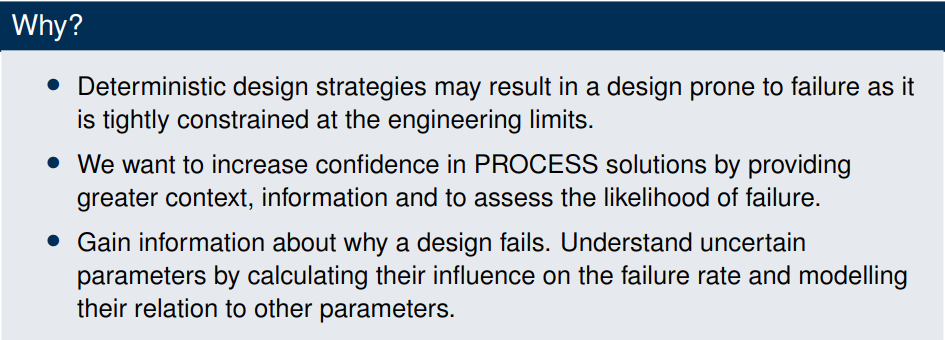

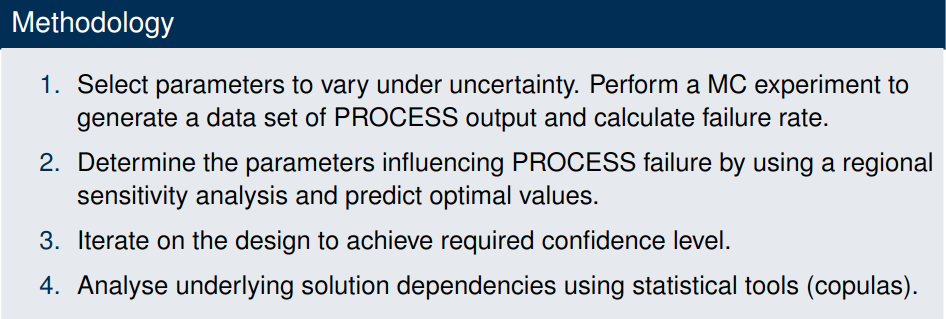

## Step 1: Define Uncertain Parameters

These bounds have been selected from past papers, and and are modelled as uniform distributions.

Unresolved task: how can we more carefully define these bounds and probability distributions?


| Parameter         | Distribution               |
|-------------------|----------------------------|
| coreradius        | Uniform(0.6, 0.9)          |
| ralpne            | Uniform(0.072, 0.0761)     |
| psepbqarmax       | Uniform(7.36, 11.04)       |
| tbrnmn            | Uniform(6954.0, 12722.0)   |
| etaech            | Uniform(0.32, 0.48)        |
| pinjalw           | Uniform(40.0, 60.0)        |
| triang            | Uniform(0.4, 0.6)          |
| alstroh           | Uniform(528000000.0, 792000000.0) |
| sig_tf_case_max   | Uniform(464000000.0, 696000000.0) |
| walalw            | Uniform(6.4, 9.6)          |
| sig_tf_wp_max     | Uniform(528000000.0, 792000000.0) |
| aspect            | Uniform(2.78, 2.94)        |
| etath             | Uniform(0.35, 0.405)       |


Note: In the following data the bounds for some parameters have been reduced, including the aspect ratio and minimum burn time.

Note: The data presented here was used to aid development, it does not represent a conclusive result.

# Optimising the DEMO design under uncertainty

### Concept

This work introduces a statistical approach for evaluating power plant designs
under uncertainty and optimising for reliability

- To leverage the use of statistics to lend greater credibility to PROCESS power plant design.
- To develop a concept of design "reliability".
- To understand why a design is "reliable", to map the interactions between uncertain parameters.
- Value-of-information (VoI) analysis to quantify the value of gaining information about a given uncertain parameter.

### Brief intro to Uncertainty
There are two ways to categorise uncertainties:
1. "Alleatory" uncertainties are irreducible and arise from inherent randomness in natural processes.
2. "Epistimic" uncertainies are a result of incomplete knowledge of a system.

### Method

- Power plants are design with some essential requirements in mind, for example it must achieve 500 MW net electric power output.
- In PROCESS we have a solver which will either converge, or not, subject to a set of input parameters and minimum requirements.
- If PROCESS cannot find a self-consistent solution to a given input, 

In [1]:
itv=[
            "bt",
            "te",
            "beta",
            "dene",
            "tfcth",
            "wallmw",
            "ohcth",
            "bigq",
            "bore",
            "betalim",
            "coheof",
            "cohbop",
            "fvsbrnni",
            # "itvar019",
            # "itvar020",
            "jwptf",
            # "vtfskv",
            # "vdalw",
            "tdmptf",
            "thkcas",
            # "thwcndut",
            "fcutfsu",
            "cpttf",
            "plhthresh",
            "tmargtf",
            "tmargoh",
            "oh_steel_frac",
            "pdivt",
            ]

In [2]:
# %load_ext autoreload
# %autoreload 1
from pathlib import Path
from bokeh.plotting import figure, show
import sys
import pandas as pd
sys.path.append('/home/graeme/process_uq/')
sys.path.append('/home/graeme/PROCESS_SALib/')
from uq_analysis import UncertaintyData, Copula, ConfidenceAnalysis
# from bokeh.plotting import figure 
from bokeh.io import output_notebook
output_notebook()
proj_dir = str(Path.cwd())+"/"
proj_dir = "/home/graeme/easyVVUQ-process/demo_analysis/"
figure_of_merit = "rmajor"
input_names = [
            "coreradius",
            "ralpne",
            "psepbqarmax",
            "tbrnmn",
            "etaech",
            "pinjalw",
            "triang",
            "alstroh",
            "sig_tf_case_max",
            "walalw",
            "sig_tf_wp_max",
            "aspect",
            "etath"
        ]
demo_1_uq_data = UncertaintyData("/home/graeme/easyVVUQ-process/demo_default_1000c_1/", figure_of_merit, input_parameters = input_names, use_scoping_data=False)
demo_1_uq_data.calculate_sensitivity(figure_of_merit)
demo_1_uq_data.calculate_failure_probability()
demo_2_uq_data = UncertaintyData("/home/graeme/easyVVUQ-process/demo_default_1000c_2/", figure_of_merit, input_parameters = input_names, use_scoping_data=False)
demo_2_uq_data.calculate_sensitivity(figure_of_merit)
demo_2_uq_data.calculate_failure_probability()


Loading BokehJS ...

## We propagate these uncertain parameters and assess the initial confidence in the design

In [3]:
print("Initial DEMO design Convergence Analysis (Baseline Confidence)")
print("Number of samples: ", len(demo_1_uq_data.uncertainties_df))
print("Number of converged runs: ",demo_1_uq_data.number_of_converged_runs,)
print("Confidence: ", round(1-demo_1_uq_data.failure_probability,2),"+/-", demo_1_uq_data.failure_cov)

Initial DEMO design Convergence Analysis (Baseline Confidence)
Number of samples:  1500
Number of converged runs:  586
Confidence:  0.39 +/- 0.02


Subject to uncertainty in these inputs, the powerplant design will meet its performance requirements ~27% of the time.

How can this be improved?

## Regional Sensitivity Analysis - which parameters influence PROCESS convergence?

A Regional Sensitivity Analysis (RSA), or Monte Carlo Filtering, is used to investigate which inputs are most responsible for producing model outputs within certain bounds.

In this technique model parameters are sampled, uncertain distributions propagated through the model. 

Output space is divided into regions of space called behavioural (desirable aka convergent) and non-behavioural (undesirable aka non-convergent).

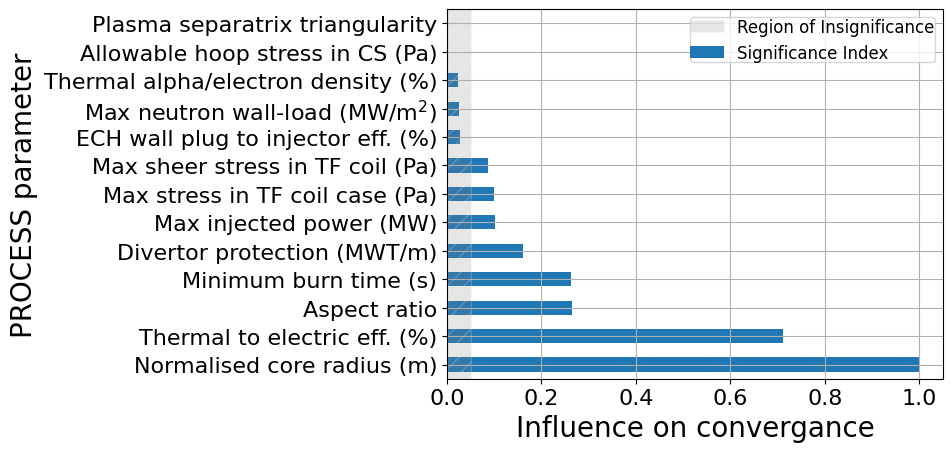

Ranked influence on convergence
['coreradius', 'etath', 'aspect', 'tbrnmn']


In [4]:
demo_1_uq_data.convergence_regional_sensitivity_analysis(demo_1_uq_data.input_names)
demo_1_uq_data.plot_sumsq_sensitivity()
demo_1_sigvar = demo_1_uq_data.find_significant_parameters(demo_1_uq_data.sumsq_sensitivity_df,"unconverged",0.2).tolist()
print("Ranked influence on convergence")
print(demo_1_sigvar)
# demo_1_itv_uq_data.convergence_regional_sensitivity_analysis(demo_1_itv_uq_data.input_names+itv)
# demo_1_itv_uq_data.plot_sumsq_sensitivity()
# significant_conv_vars = demo_1_itv_uq_data.find_significant_parameters(demo_1_itv_uq_data.sumsq_sensitivity_df,"unconverged",0.4).tolist()
# print("Ranked influence on convergence")
# print(significant_conv_vars)

## Now the converged output is analysed.

A simple algorithm is used to perform interval analysis. The parameter space is divided into intervals, and each interval has an associated standard error.

The algorithm looks for the optimal number of intervals to use to reduce the parameter space to increase confidence, while accounting for this standard error.

For example:
- It is difficult to resolve the `normalised core radius` into smaller intervals.
- The `minimum burn time` can be confidently divided into two intervals. 
    - A `minimum burn time` in the range 9821 - 12629 [s] will lead to higher design reliability.

The current design point is marked by a red line, and the optimal design space is marked with a green line.


In [5]:
demo_1_con_analysis=ConfidenceAnalysis(demo_1_uq_data,input_names=input_names, weight_confidence=1.0,weight_overlap=0.1, num_intervals=10)#,custom_data_point=custom_data)
show(demo_1_con_analysis.create_graph_grid(input_names))
show(demo_1_con_analysis.create_datatable(input_names))

Output variables can be tracked to observe changes in the design throughout the optimisation process.

It is predicted that the `major radius` and `fusion power` will decrease as the design reliability increases.

## Optimise the design: 1st cycle
Now we update our Monte Carlo experiment with the optimal bounds predicted in the table above.

In [6]:
# vary={"coreradius": cp.Uniform(0.6,0.75),
#       "ralpne": cp.Uniform(0.072,0.0761),
#       "psepbqarmax": cp.Uniform(9.20,11.02),
#       "tbrnmn": cp.Uniform(6955.86,12696.0),
#       "etaech": cp.Uniform(0.40,0.48),
#       "pinjalw": cp.Uniform(40.0,49.0),
#       "triang": cp.Uniform(0.4,0.6),
#       "alstroh": cp.Uniform(529700000.0,788900000.0),
#       "sig_tf_case_max": cp.Uniform(580100000.0,695500000.0),
#       "walalw": cp.Uniform(6.4,9.6),
#       "sig_tf_wp_max": cp.Uniform(658600000.0,789200000.0),
#       "aspect": cp.Uniform(2.86,2.94),
#       "etath": cp.Uniform(0.38,0.405)}
# mc_sampler = uq.sampling.MCSampler(vary=vary,n_mc_samples=100)

In [7]:
print("Initial DEMO design Convergence Analysis (Baseline Confidence)")
print("Number of samples: ", len(demo_2_uq_data.uncertainties_df))
print("Number of converged runs: ",demo_2_uq_data.number_of_converged_runs,)
print("Confidence: ", round(1-demo_2_uq_data.failure_probability,2),"+/-", demo_2_uq_data.failure_cov)

Initial DEMO design Convergence Analysis (Baseline Confidence)
Number of samples:  1500
Number of converged runs:  1080
Confidence:  0.72 +/- 0.02


This has improved the convergence rate, as predicted. 

Now repeat the analysis, what has changed?

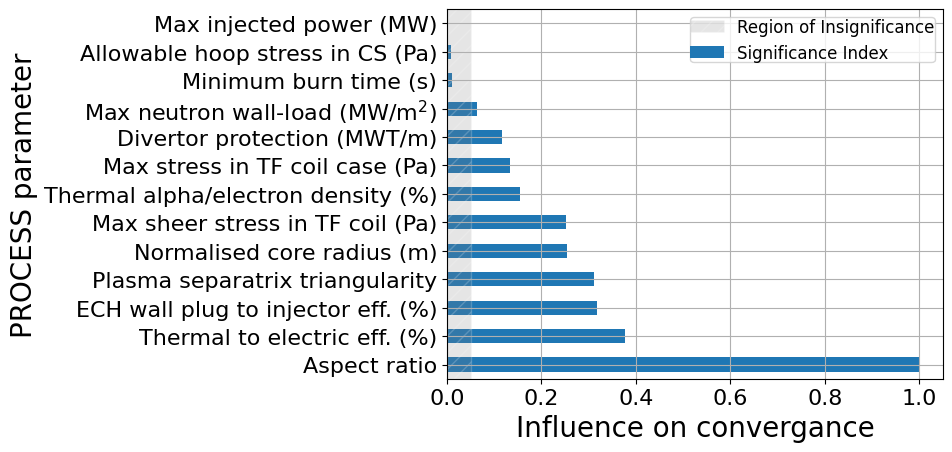

Ranked influence on convergence
['aspect', 'etath', 'etaech', 'triang']


In [8]:
demo_2_uq_data.convergence_regional_sensitivity_analysis(demo_2_uq_data.input_names)
demo_2_uq_data.plot_sumsq_sensitivity()
significant_conv_vars = demo_2_uq_data.find_significant_parameters(demo_2_uq_data.sumsq_sensitivity_df,"unconverged",0.3).tolist()
print("Ranked influence on convergence")
print(significant_conv_vars)

The ranking of parameters as changed as some values have been changed. 

This allows previously insignificant parameters to be optimised.

In [9]:
demo_2_con_analysis=ConfidenceAnalysis(demo_2_uq_data,input_names=input_names+["beta"], weight_confidence=1.0,weight_overlap=0.10, num_intervals=10)#,custom_data_point=custom_data)
show(demo_2_con_analysis.create_graph_grid(input_names))
show(demo_2_con_analysis.create_datatable(input_names))

1. I just take the updated bounds from the table (aspect, etath, triang, burntime)

In [10]:
# vary={"coreradius": cp.Uniform(0.6,0.75),
#       "ralpne": cp.Uniform(0.072,0.0761),
#       "psepbqarmax": cp.Uniform(9.20,11.02),
#       "tbrnmn": cp.Uniform(9819.35,12680.82),
#       "etaech": cp.Uniform(0.40,0.48),
#       "pinjalw": cp.Uniform(40.0,49.0),
#       "triang": cp.Uniform(0.5,0.6),
#       "alstroh": cp.Uniform(529700000.0,788900000.0),
#       "sig_tf_case_max": cp.Uniform(580100000.0,695500000.0),
#       "walalw": cp.Uniform(6.4,9.6),
#       "sig_tf_wp_max": cp.Uniform(658600000.0,789200000.0),
#       "aspect": cp.Uniform(2.86,2.90),
#       "etath": cp.Uniform(0.39,0.405)}
# mc_sampler = uq.sampling.MCSampler(vary=vary,n_mc_samples=100)

# What is constraining the optimised design?

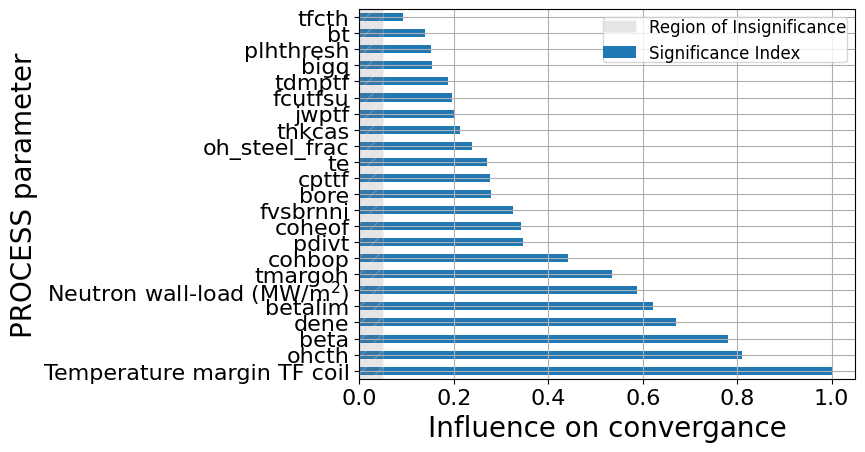

['tmargtf', 'ohcth', 'beta', 'dene', 'betalim']


In [11]:
demo_2_uq_data.convergence_regional_sensitivity_analysis(itv)
demo_2_uq_data.plot_sumsq_sensitivity()
significant_itv_vars = demo_2_uq_data.find_significant_parameters(demo_2_uq_data.sumsq_sensitivity_df,"unconverged",0.6).tolist()
print(significant_itv_vars)

/home/graeme/process_uq/uqenv/lib/python3.10/site-packages/copulas/multivariate/vine.py:73: UserWarning: Vines have not been fully tested on Python >= 3.8 and might produce wrong results.
  warnings.warn(
/home/graeme/process_uq/uqenv/lib/python3.10/site-packages/copulas/bivariate/base.py:162: RuntimeWarning: Data does not appear to be uniform.
  warnings.warn('Data does not appear to be uniform.', category=RuntimeWarning)


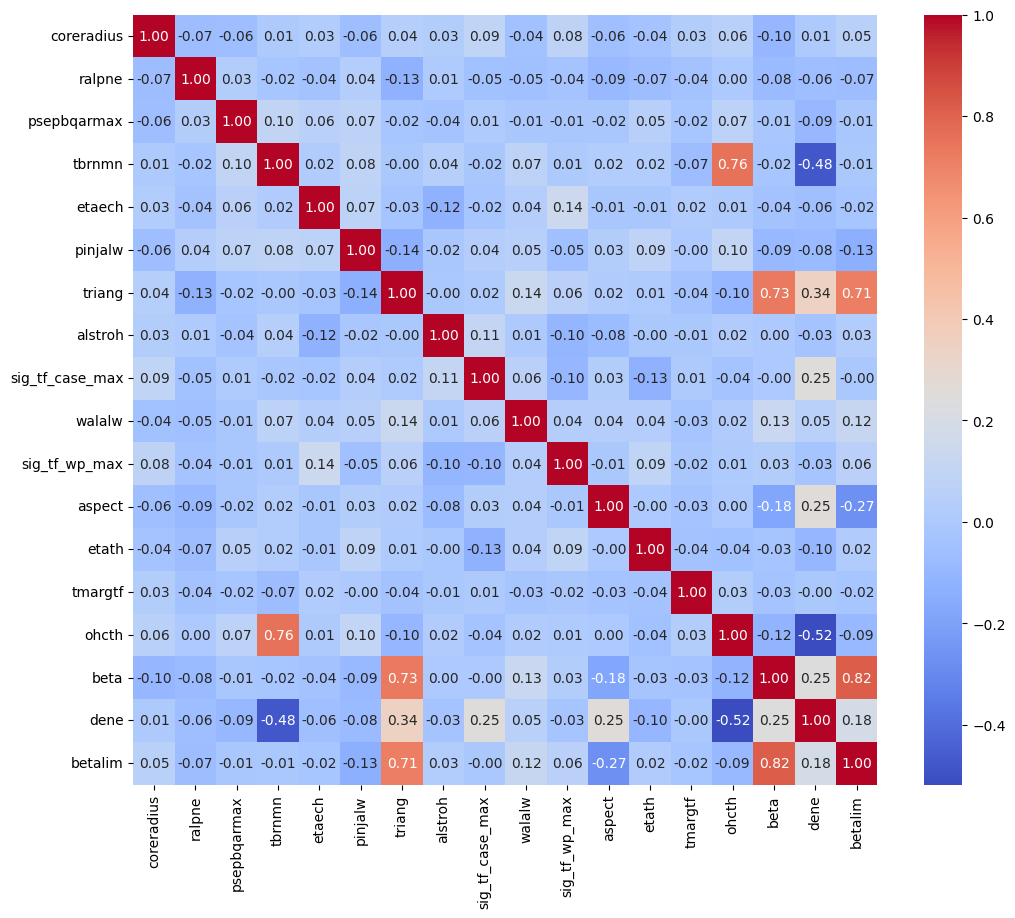

In [12]:
model_parameters = input_names+significant_itv_vars
demo_2_con_analysis=ConfidenceAnalysis(demo_2_uq_data,input_names=demo_2_uq_data.input_names+model_parameters, weight_confidence=1.0,weight_overlap=0.1, num_intervals=10)#,custom_data_point=custom_data)
vcopula = Copula(demo_2_uq_data.converged_df,model_parameters,copula_type="vine")
vcopula.calculate_copula(synthetic_sample_size=50)
vcopula.copula.tau_mat
correlation_df = pd.DataFrame(vcopula.copula.tau_mat,columns=model_parameters,index=model_parameters)
vcopula.plot_correlation_matrix(correlation_df)

In [15]:
demo_2_con_analysis.plot_network(demo_2_con_analysis.correlation_network(correlation_matrix=correlation_df,variables=input_names+model_parameters,threshold=0.3))

Plotting all sampled parameters


tbrnmn    1.0
dtype: float64

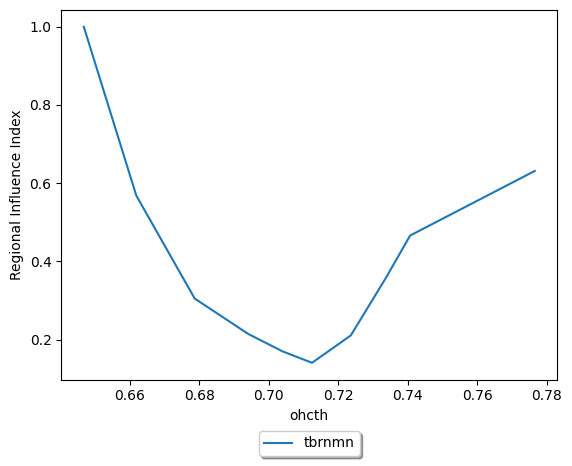

In [16]:
demo_2_uq_data.configure_data_for_plotting()
demo_2_uq_data.regional_sensitivity_analysis(figure_of_merit="ohcth",variables_to_sample=input_names,dataframe=demo_2_uq_data.converged_df,confidence_level=0.2)